<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_amds.png?raw=1" alt="Logo" width=128px>

# AmsterdamUMCdb - Freely Accessible ICU Database

version 1.0.2 March 2020  
Copyright &copy; 2003-2022 Amsterdam UMC - Amsterdam Medical Data Science

## Sequential Organ Failure Assessment (SOFA)
The sequential organ failure assessment score (SOFA score), originally published as as the Sepsis-related Organ Failure Assessment score ([Vincent et al., 1996](http://link.springer.com/10.1007/BF01709751)), is a disease severity score designed to track the severity of critical ilness throughout the ICU stay. In contrast to APACHE (II/IV), which only calculates a score for the first 24 hours, it can be used sequentially for every following day. The code performs some data cleanup and calculates the SOFA score for the first 24 hours of ICU admission for all patients in the database.

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import io
from IPython.display import display, HTML, Markdown

## Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')

#uncomment for higher-resolution (print-ready) versions
#plt.rcParams["figure.dpi"] = 288
#plt.rcParams["figure.figsize"] = [16, 12]
#plt.rcParams["font.size"] = 12

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../../config.ini'):
    config.read('../../config.ini')
else:
    config.read('../../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

In [4]:
#loads the admissions table for stratification on admission unit 
sql = """
SELECT * FROM admissions;
"""
admissions = pd.read_sql(sql,con)

In [5]:
#No. patients
no_patients_total = admissions.patientid.nunique()
no_patients_ICU = admissions[admissions['location'].str.contains('IC')].patientid.nunique()
no_patients_MCU = admissions[admissions['location'].str.contains('^MC$')].patientid.nunique()

#No. admissions
no_admissions_total = admissions.admissionid.nunique()
no_admissions_ICU = admissions[admissions['location'].str.contains('IC')].admissionid.nunique()
no_admissions_MCU = admissions[admissions['location'].str.contains('^MC$')].admissionid.nunique()

In [6]:
#loads the dictionary from the amsterdamumcdb package for fast lookup
dictionary = amsterdamumcdb.get_dictionary()
listitems_itemids = dictionary[dictionary['table'] == 'listitems'][['itemid','item','item_en','valueid','value','count','count_validated']]
numericitems_itemids = dictionary[dictionary['table'] == 'numericitems'][['itemid','item','item_en','unitid','unit','count','count','count_validated']]

### SOFA
At day 1 (=first 24 hours of ICU/MCU admission)

#### Respiration PaO2/FiO2, mmHg
Since the original Vincent (1996) article did not specify estimation of FiO2 for patients without ventilatory support, we use the Stichting NICE [conversion table](https://www.stichting-nice.nl/dd/#468) based on oxygen flow and device used.

In [7]:
# Oxygen device possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:^|\_|(?<=\W))(?:O2|zuurstof|toediening)\w*(?:$|\_|(?=\W))',
                                                               flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
870,8845,O2 l/min,oxygen flow (l/min),26.0,l/min,656405,656405,656405.0
889,8869,O2 Volume,NaN,0.0,None,85386,85386,77406.0
1604,9664,O2 Volume(2),NaN,0.0,None,5,5,5.0
1844,10282,O2-Content (bloed),NaN,88.0,ml/dl,341313,341313,341313.0
1845,10283,O2-CONTENT (overig),NaN,88.0,ml/dl,5,5,5.0
1889,10387,Zuurstof toediening (bloed),NaN,26.0,l/min,8229,8229,8229.0
2390,11425,O2sat (overig),NaN,191.0,Geen,2,2,2.0
2890,12279,O2 concentratie,inspired oxygen concentration measurement,191.0,Geen,15645395,15645395,1274067.0
2893,12282,O2 concentratie (Set),inspired oxygen concentration setting,191.0,Geen,15645752,15645752,1281165.0
2934,12311,O2-Saturatie (bloed),NaN,191.0,Geen,652901,652901,652901.0


In [8]:
#get oxygen device and corresponding oxygen flow
with open('../../amsterdamumcdb/sql/common/oxygen_device.sql') as sql_file:
    sql_oxy_flow = sql_file.read()
    display(Markdown("```sql\n" + sql_oxy_flow + "\n```"))
oxy_flow = pd.read_sql(sql_oxy_flow, con)
oxy_flow.head()

```sql
SELECT
    oxy_dev.admissionid,
    oxy_dev.valueid,
    oxy_dev.value as O2_device,
    oxy_dev.measuredat,
    oxy_flow.value AS O2_flow
FROM listitems oxy_dev
LEFT JOIN admissions a ON
    oxy_dev.admissionid = a.admissionid
LEFT JOIN numericitems oxy_flow ON
    oxy_dev.admissionid = oxy_flow.admissionid AND
    oxy_dev.measuredat = oxy_flow.measuredat AND
    oxy_flow.itemid IN (
        8845, -- O2 l/min
        10387, --Zuurstof toediening (bloed)
        18587 --Zuurstof toediening
    )
WHERE oxy_dev.itemid = 8189 -- Toedieningsweg (Oxygen device)
    -- measurements within 24 hours of ICU stay:
    AND (oxy_dev.measuredat - a.admittedat) <= 1000*60*60*24 AND (oxy_dev.measuredat - a.admittedat) >= 0
```

,admissionid,valueid,o2_device,measuredat,o2_flow
0,55,7,O2-bril,30120000,3.0
1,55,7,O2-bril,33720000,3.0
2,55,7,O2-bril,37320000,3.0
3,55,7,O2-bril,40920000,3.0
4,55,7,O2-bril,44520000,4.0


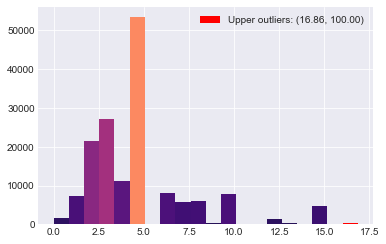

In [9]:
amsterdamumcdb.outliers_histogram(data=oxy_flow['o2_flow'].dropna(), bins=20).show()

In [10]:
oxy_flow.loc[(oxy_flow['o2_flow'] < 1), 'o2_flow'].unique()

array([0. , 0.5])

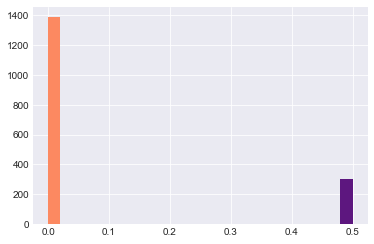

In [11]:
amsterdamumcdb.outliers_histogram(data=oxy_flow.loc[(oxy_flow['o2_flow'] < 1), 'o2_flow']).show()

In [12]:
oxy_flow.loc[(oxy_flow['o2_flow'] > 15), 'o2_flow'].unique()

array([ 16. ,  20. , 100. ,  17. ,  22. ,  25. ,  15.7,  18. ,  30. ,
        19. ])

In [13]:
oxy_flow.loc[(oxy_flow['o2_flow'] > 15)].sort_values(by='o2_flow')

,admissionid,valueid,o2_device,measuredat,o2_flow
33565,4918,8,Kinnebak,59700000,15.7
33568,4918,1,Diep Nasaal,66900000,15.7
33566,4918,1,Diep Nasaal,59700000,15.7
33567,4918,8,Kinnebak,66900000,15.7
45761,6724,17,Non-Rebreathing masker,84960000,16.0
46993,6918,17,Non-Rebreathing masker,263760000,16.0
46992,6918,17,Non-Rebreathing masker,249360000,16.0
46991,6918,1,Diep Nasaal,249360000,16.0
46990,6918,17,Non-Rebreathing masker,242160000,16.0
46989,6918,1,Diep Nasaal,242160000,16.0


In [14]:
#get PaO2 and FiO2 values
# simultaneously retrieve PaCO2 and the 'nearest' FiO2 from the ventilator or estimated FiO2 based on applied oxygen
# device. Ideally documentation of measurements should be at the same time, but since this is not garanteed allow a window.
#
# in more recent data PaCO2 and PaO2 were documented in kPa instead of mmHg.
with open('../../amsterdamumcdb/sql/common/pO2_FiO2_estimated.sql') as sql_file:
    sql_sofa_respiration = sql_file.read()
    display(Markdown("```sql\n" + sql_sofa_respiration + "\n```"))
sofa_respiration = pd.read_sql(sql_sofa_respiration, con)
sofa_respiration.head()

```sql
WITH fio2_table AS (
    SELECT n.admissionid,
        n.measuredat,
        l.valueid,
        l.value AS O2_device,
        CASE
            WHEN n.itemid IN (
                --FiO2 settings on respiratory support
                6699, --FiO2 %: setting on Evita ventilator
                12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
                12369, --SET %O2: used with BiPap Vision ventilator
                16246 --Zephyros FiO2: Non-invasive ventilation
            ) THEN TRUE
            ELSE FALSE
        END AS ventilatory_support,
        CASE
            WHEN n.itemid IN (
                --FiO2 settings on respiratory support
                6699, --FiO2 %: setting on Evita ventilator
                12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
                12369, --SET %O2: used with BiPap Vision ventilator
                16246 --Zephyros FiO2: Non-invasive ventilation
            ) THEN
                CASE
                    WHEN NOT n.value IS NULL THEN n.value --use the settings
                    ELSE 0.21
                END
            ELSE -- estimate the FiO2
                CASE
                    WHEN l.valueid IN (
                        2, -- Nasaal
                        7 --O2-bril
                    ) THEN
                        CASE
                            WHEN n.value >= 1 AND n.value < 2 THEN 0.22
                            WHEN n.value >= 2 AND n.value < 3 THEN 0.25
                            WHEN n.value >= 3 AND n.value < 4 THEN 0.27
                            WHEN n.value >= 4 AND n.value < 5 THEN 0.30
                            WHEN n.value >= 5 THEN 0.35
                            ELSE 0.21
                        END
                    WHEN l.valueid IN (
                        1, --Diep Nasaal
                        3, --Kapje
                        8, --Kinnebak
                        9, --Nebulizer
                        4, --Kunstneus
                        18, --Spreekcanule
                        19 --Spreekklepje
                    ) THEN
                        CASE
                            WHEN n.value >= 1 AND n.value < 2 THEN 0.22 -- not defined by NICE
                            WHEN n.value >= 2 AND n.value < 3 THEN 0.25
                            WHEN n.value >= 3 AND n.value < 4 THEN 0.27
                            WHEN n.value >= 4 AND n.value < 5 THEN 0.30
                            WHEN n.value >= 5 AND n.value < 6 THEN 0.35
                            WHEN n.value >= 6 AND n.value < 7 THEN 0.40
                            WHEN n.value >= 7 AND n.value < 8 THEN 0.45
                            WHEN n.value >= 8 THEN 0.50
                            ELSE 0.21
                        END
                    WHEN l.valueid IN (
                        10, --Waterset
                        11, --Trach.stoma
                        13, --Ambu
                        14, --Guedel
                        15, --DL-tube
                        16, --CPAP
                        17 --Non-Rebreathing masker
                    ) THEN
                        CASE
                            WHEN n.value >= 6 AND n.value < 7 THEN 0.60
                            WHEN n.value >= 7 AND n.value < 8 THEN 0.70
                            WHEN n.value >= 8 AND n.value < 9 THEN 0.80
                            WHEN n.value >= 9 AND n.value < 10 THEN 0.85
                            WHEN n.value >= 10 THEN 0.90
                            ELSE 0.21
                        END
                    WHEN l.valueid IN (
                        12 --B.Lucht
                    ) THEN 0.21
                ELSE 0.21
            END
        END AS fio2
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    LEFT JOIN listitems l ON
        n.admissionid = l.admissionid AND
        n.measuredat = l.measuredat AND
        l.itemid = 8189 -- Toedieningsweg (Oxygen device)
    WHERE
        n.itemid IN (
            --Oxygen Flow settings without respiratory support
            8845, -- O2 l/min
            10387, --Zuurstof toediening (bloed)
            18587, --Zuurstof toediening

            --FiO2 settings on respiratory support
            6699, --FiO2 %: setting on Evita ventilator
            12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
            12369, --SET %O2: used with BiPap Vision ventilator
            16246 --Zephyros FiO2: Non-invasive ventilation
        )
    --measurements within 24 hours of ICU stay:
    AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= 0
    AND n.value > 0 --ignore stand by values from Evita ventilator
),
oxygenation AS (
    SELECT
        pao2.admissionid,
        CASE pao2.unitid
            WHEN 152 THEN pao2.value * 7.50061683 -- Conversion: kPa to mmHg
            ELSE pao2.value
        END AS pao2,
        f.value AS specimen_source,
        CASE
            WHEN pao2.registeredby NOT ILIKE '%Systeem%' THEN TRUE
            ELSE FALSE
        END AS manual_entry,
        (pao2.measuredat - a.admittedat)/(1000*60) AS time,
        fio2_table.fio2,
        fio2_table.ventilatory_support,
        (fio2_table.measuredat - pao2.measuredat)/(60*1000) AS FiO2_time_difference,
        ROW_NUMBER() OVER(
            PARTITION BY pao2.admissionid, pao2.measuredat
            ORDER BY ABS(fio2_table.measuredat - pao2.measuredat)
        ) AS priority --give priority to nearest FiO2 measurement
    FROM numericitems pao2
    LEFT JOIN admissions a ON
        pao2.admissionid = a.admissionid
    LEFT JOIN freetextitems f ON
        pao2.admissionid = f.admissionid AND
        pao2.measuredat = f.measuredat AND
        f.itemid = 11646 --Afname (bloed): source of specimen
    LEFT JOIN numericitems paco2 ON
        pao2.admissionid = paco2.admissionid AND
        pao2.measuredat = paco2.measuredat AND
        paco2.itemid IN (
            6846, --PCO2
            9990, --pCO2 (bloed)
            21213 --PCO2 (bloed) - kPa
        )
    LEFT JOIN fio2_table ON
        pao2.admissionid = fio2_table.admissionid AND
        fio2_table.measuredat > pao2.measuredat - 60*60*1000 AND --no earlier than 60 minutes before pao2 measurement
        fio2_table.measuredat < pao2.measuredat + 15*60*1000 --no later than 15 minutes after pao2 measurement
    WHERE
        pao2.itemid IN (
            7433, --PO2
            9996, --PO2 (bloed)
            21214 --PO2 (bloed) - kPa
        )
    --measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
    AND (pao2.measuredat - a.admittedat) <= 1000*60*60*24 AND (pao2.measuredat - a.admittedat) >= -(1000*60*30) AND
    (f.value ILIKE '%art.%' OR f.value IS NULL)  -- source is arterial or undefined (assume arterial)
)
SELECT * FROM oxygenation
WHERE priority = 1
```

,admissionid,pao2,specimen_source,manual_entry,time,fio2,ventilatory_support,fio2_time_difference,priority
0,0,90.0,None,True,342,50.0,True,0.0,1
1,0,149.0,None,True,432,51.0,True,0.0,1
2,0,104.0,None,True,552,41.0,True,0.0,1
3,0,32.0,None,True,612,41.0,True,0.0,1
4,0,105.0,None,True,732,41.0,True,0.0,1


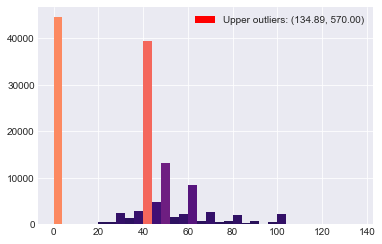

In [15]:
amsterdamumcdb.outliers_histogram(data=sofa_respiration['fio2'].dropna()).show()

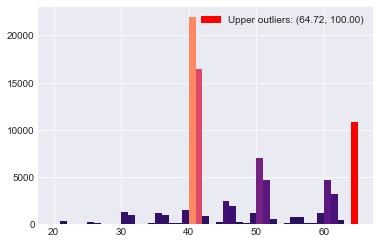

In [16]:
amsterdamumcdb.outliers_histogram(data=sofa_respiration.loc[(sofa_respiration['fio2'] >= 20) & 
                                                            (sofa_respiration['fio2'] <=100), 'fio2']).show()

In [17]:
#remove extreme outliers
sofa_respiration.loc[(sofa_respiration['fio2'] > 100), 'fio2'] = np.NaN

#convert FiO2 in % to fraction
sofa_respiration.loc[(sofa_respiration['fio2'] <= 100) & 
                     (sofa_respiration['fio2'] >= 20) , 'fio2'] = sofa_respiration['fio2']/100

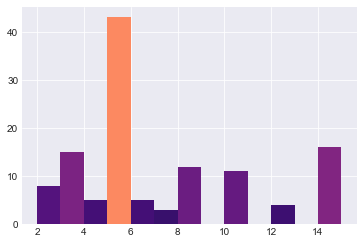

In [18]:
amsterdamumcdb.outliers_histogram(data=sofa_respiration.loc[(sofa_respiration['fio2'] > 1), 'fio2']).show()

In [19]:
#remove extreme outliers (FiO2) (possible O2 flow?)
sofa_respiration.loc[(sofa_respiration['fio2'] > 1), 'fio2'] = np.NaN

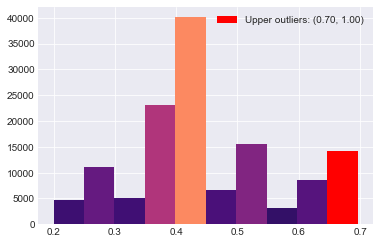

In [20]:
amsterdamumcdb.outliers_histogram(data=sofa_respiration['fio2'].dropna(), bins=10).show()

In [21]:
#remove lower outliers, most likely incorrectly labeled as 'arterial' instead of '(mixed/central) venous'
sofa_respiration.loc[sofa_respiration['pao2'] < 50, 'pao2'] = np.NaN
sofa_respiration = sofa_respiration.dropna(subset=['pao2'])

In [22]:
sofa_respiration.loc[:,'pf_ratio'] = sofa_respiration['pao2']/sofa_respiration['fio2']
sofa_respiration.head()

,admissionid,pao2,specimen_source,manual_entry,time,fio2,ventilatory_support,fio2_time_difference,priority,pf_ratio
0,0,90.0,None,True,342,0.50,True,0.0,1,180.000000
1,0,149.0,None,True,432,0.51,True,0.0,1,292.156863
2,0,104.0,None,True,552,0.41,True,0.0,1,253.658537
4,0,105.0,None,True,732,0.41,True,0.0,1,256.097561
5,0,90.0,None,True,927,0.41,True,-15.0,1,219.512195


In [23]:
#calculate SOFA respiration score:
sofa_respiration.loc[:,'sofa_respiration_score'] = 0
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 400) & 
                     (sofa_respiration['pf_ratio'] >= 300), 'sofa_respiration_score'] = 1
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 300), 'sofa_respiration_score'] = 2
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 200) & (sofa_respiration['pf_ratio'] >= 100) &
                     (sofa_respiration['ventilatory_support'] == True), 'sofa_respiration_score'] = 3
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 100) & 
                     (sofa_respiration['ventilatory_support'] == True), 'sofa_respiration_score'] = 4
sofa_respiration.head()

,admissionid,pao2,specimen_source,manual_entry,time,fio2,ventilatory_support,fio2_time_difference,priority,pf_ratio,sofa_respiration_score
0,0,90.0,None,True,342,0.50,True,0.0,1,180.000000,3
1,0,149.0,None,True,432,0.51,True,0.0,1,292.156863,2
2,0,104.0,None,True,552,0.41,True,0.0,1,253.658537,2
4,0,105.0,None,True,732,0.41,True,0.0,1,256.097561,2
5,0,90.0,None,True,927,0.41,True,-15.0,1,219.512195,2


#### SOFA: Coagulation - Platelets x 10^3/mm^3

In [24]:
#  SOFA: Coagulation - Platelets x 10^3/mm^3 - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:^|(?<=\W))t(?:h)?rombo(?:cyten)?(?:$|(?=\W))', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
122,6797,Thrombocyten,platelets,101.0,10^9/l,7201,7201,7201.0
1711,9964,Thrombo's (bloed),platelets,101.0,10^9/l,214452,214452,214452.0
1874,10356,THROMBO'S (overig),NaN,101.0,10^9/l,13,13,13.0
1897,10409,Thrombo's citr. bloed (bloed),platelets - in citrate anticoagulated blood measurement,101.0,10^9/l,60,60,60.0
4002,14252,Thrombo CD61 (bloed),platelets - CD61 flow cytometry measurement,101.0,10^9/l,393,393,393.0
8630,20018,Streef Thrombo's onderwaarde,NaN,101.0,10^9/l,340,340,340.0


In [25]:
#get platelets (thrombocytes)
with open('../../amsterdamumcdb/sql/common/platelets.sql') as sql_file:
    sql_sofa_platelets = sql_file.read()
    display(Markdown("```sql\n" + sql_sofa_platelets + "\n```"))
sofa_platelets = pd.read_sql(sql_sofa_platelets, con)
sofa_platelets.head()

```sql
SELECT
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE
        WHEN n.registeredby NOT ILIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    9964, --Thrombo's (bloed)
    6797, --Thrombocyten
    10409, --Thrombo's citr. bloed (bloed)
    14252 --Thrombo CD61 (bloed)
    )
--measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)
```

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,12,6797,Thrombocyten,117.0,ICV_IC-Verpleegkundig,True,375
1,43,6797,Thrombocyten,106.0,ICV_Medisch,True,20
2,43,6797,Thrombocyten,105.0,ICV_IC-Verpleegkundig,True,830
3,102,6797,Thrombocyten,124.0,ICV_Medisch,True,60
4,130,6797,Thrombocyten,110.0,ICV_Medisch,True,181


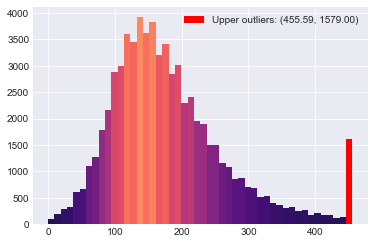

In [26]:
amsterdamumcdb.outliers_histogram(data=sofa_platelets['value'],bins=48).show()

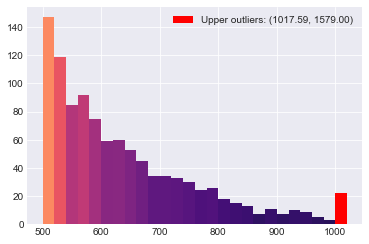

In [27]:
amsterdamumcdb.outliers_histogram(data=sofa_platelets.loc[(sofa_platelets['value'] > 500) & (sofa_platelets['manual_entry'] == False), 'value']).show()

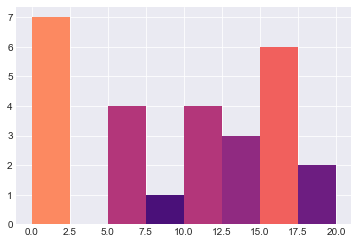

In [28]:
amsterdamumcdb.outliers_histogram(data=sofa_platelets.loc[(sofa_platelets['value'] < 20) & (sofa_platelets['manual_entry'] == True), 'value']).show()

In [29]:
#calculate SOFA coagulation score:
sofa_platelets.loc[:,'sofa_coagulation_score'] = 0
sofa_platelets.loc[(sofa_platelets['value'] < 150) & 
                     (sofa_platelets['value'] >= 100), 'sofa_coagulation_score'] = 1
sofa_platelets.loc[(sofa_platelets['value'] < 100) & 
                     (sofa_platelets['value'] >= 50), 'sofa_coagulation_score'] = 2
sofa_platelets.loc[(sofa_platelets['value'] < 50) & 
                     (sofa_platelets['value'] >= 20), 'sofa_coagulation_score'] = 3
sofa_platelets.loc[(sofa_platelets['value'] < 20), 'sofa_coagulation_score'] = 4

sofa_platelets.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time,sofa_coagulation_score
0,12,6797,Thrombocyten,117.0,ICV_IC-Verpleegkundig,True,375,1
1,43,6797,Thrombocyten,106.0,ICV_Medisch,True,20,1
2,43,6797,Thrombocyten,105.0,ICV_IC-Verpleegkundig,True,830,1
3,102,6797,Thrombocyten,124.0,ICV_Medisch,True,60,1
4,130,6797,Thrombocyten,110.0,ICV_Medisch,True,181,1


#### SOFA: Liver - Bilirubin, µmol/l

In [30]:
#  SOFA:Liver - Bilirubin, µmol/l
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:^|(?<=\W))bili(?:rubine)?(?:$|(?=\W))', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
140,6812,Bilirubine geconjugeerd,NaN,56.0,µmol,375,375,375.0
141,6813,Bili Totaal,bilirubin total,56.0,µmol,1720,1720,1720.0
1693,9945,Bilirubine (bloed),bilirubin total,99.0,µmol/l,57386,57386,57386.0
1694,9946,BILIRUBINE (overig),NaN,99.0,µmol/l,149,149,149.0
1883,10377,Bili (Liq) (liquor),NaN,99.0,µmol/l,1,1,1.0
2632,12079,Gecon.Bili (bloed),NaN,214.0,x TOT,4317,4317,4317.0
2633,12080,Gecon.Bili (overig),NaN,214.0,x TOT,11,11,11.0
6766,17993,Bilirubine ascitesvocht (ascitesvocht),NaN,99.0,µmol/l,18,18,18.0
6835,18361,Gecon.Bili (bloed),NaN,99.0,µmol/l,2098,2098,2098.0
7961,18851,Bilirubine drainvocht (drain),NaN,99.0,µmol/l,181,181,181.0


In [31]:
#get bilirubin
with open('../../amsterdamumcdb/sql/common/bilirubin.sql') as sql_file:
    sql_sofa_bilirubin = sql_file.read()
    display(Markdown("```sql\n" + sql_sofa_bilirubin + "\n```"))
sofa_bilirubin = pd.read_sql(sql_sofa_bilirubin, con)
sofa_bilirubin.head()

```sql
SELECT
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE
        WHEN n.registeredby NOT ILIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
    WHERE n.itemid IN (
        6813, --Bili Totaal
        9945 --Bilirubine (bloed)
    )
--measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)
```

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,12,6813,Bili Totaal,16.0,ICV_Medisch,True,15
1,291,6813,Bili Totaal,15.0,ICV_IC-Verpleegkundig,True,29
2,291,6813,Bili Totaal,18.0,ICV_Medisch,True,809
3,559,6813,Bili Totaal,11.0,ICV_IC-Verpleegkundig,True,55
4,564,6813,Bili Totaal,15.0,ICV_IC-Verpleegkundig,True,93


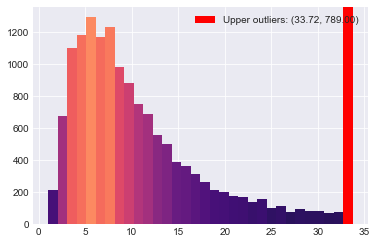

In [32]:
amsterdamumcdb.outliers_histogram(data=sofa_bilirubin['value'],bins=32).show()

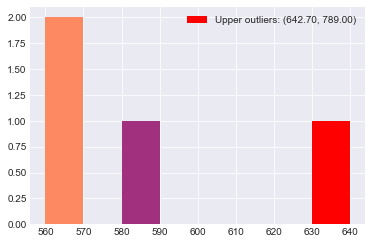

In [33]:
amsterdamumcdb.outliers_histogram(data=sofa_bilirubin.loc[(sofa_bilirubin['value'] > 500) & (sofa_bilirubin['manual_entry'] == False), 'value']).show()

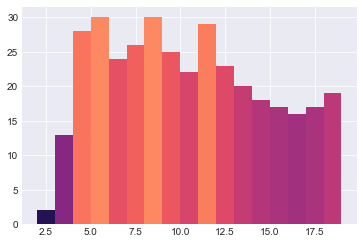

In [34]:
amsterdamumcdb.outliers_histogram(data=sofa_bilirubin.loc[(sofa_bilirubin['value'] < 20) & (sofa_bilirubin['manual_entry'] == True), 'value']).show()

In [35]:
#calculate SOFA liver score:
sofa_bilirubin.loc[:,'sofa_liver_score'] = 0
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 20) & (sofa_bilirubin['value'] < 33), 'sofa_liver_score'] = 1
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 33) & (sofa_bilirubin['value'] < 102), 'sofa_liver_score'] = 2
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 102) & (sofa_bilirubin['value'] < 204), 'sofa_liver_score'] = 3
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 204), 'sofa_liver_score'] = 4

sofa_bilirubin.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time,sofa_liver_score
0,12,6813,Bili Totaal,16.0,ICV_Medisch,True,15,0
1,291,6813,Bili Totaal,15.0,ICV_IC-Verpleegkundig,True,29,0
2,291,6813,Bili Totaal,18.0,ICV_Medisch,True,809,0
3,559,6813,Bili Totaal,11.0,ICV_IC-Verpleegkundig,True,55,0
4,564,6813,Bili Totaal,15.0,ICV_IC-Verpleegkundig,True,93,0


#### SOFA: Cardiovascular - Hypotension

##### cardiovascular medication: vasopressors and/or inotropes

In [36]:
with open('../../amsterdamumcdb/sql/common/vasopressors_inotropes.sql', encoding = 'utf-8') as sql_file:
    sql_sofa_cardiovascular = sql_file.read()
    display(Markdown("```sql\n" + sql_sofa_cardiovascular + "\n```"))
sofa_cardiovascular = pd.read_sql(sql_sofa_cardiovascular,con)
sofa_cardiovascular.head()

```sql
WITH dosing AS (
    SELECT  
        drugitems.admissionid, 
        itemid,
        item,
        (start - admissions.admittedat)/(1000*60) AS start_time, 
        (stop - admissions.admittedat)/(1000*60) AS stop_time, 
        duration,
        rate,
        rateunit,
        dose,
        doseunit,
        doseunitid,
        doserateperkg,
        doserateunitid,
        doserateunit,
        CASE
            WHEN weightgroup LIKE '59' THEN 55
            WHEN weightgroup LIKE '60' THEN 65
            WHEN weightgroup LIKE '70' THEN 75
            WHEN weightgroup LIKE '80' THEN 85
            WHEN weightgroup LIKE '90' THEN 95
            WHEN weightgroup LIKE '100' THEN 105
            WHEN weightgroup LIKE '110' THEN 115
            ELSE 80 --mean weight for all years
        END as patientweight
    FROM drugitems 
    LEFT JOIN admissions 
    ON drugitems.admissionid = admissions.admissionid
    WHERE ordercategoryid = 65 -- continuous i.v. perfusor
    AND itemid IN (
            7179, -- Dopamine (Inotropin)
            7178, -- Dobutamine (Dobutrex)
            6818, -- Adrenaline (Epinefrine)
            7229  -- Noradrenaline (Norepinefrine)
        )
    AND rate > 0.1
)
SELECT 
    admissionid,
    itemid,
    item,
    duration,
    rate,
    rateunit,
    start_time,
    stop_time,
    CASE 
    --recalculate the dose to µg/kg/min ('gamma')
    WHEN doserateperkg = B'0' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/min -> µg/kg/min
        THEN CASE 
            WHEN patientweight > 0
            THEN dose/patientweight
            ELSE dose/80 --mean weight
        END
    WHEN doserateperkg = B'0' AND doseunitid = 10 AND
    doserateunitid = 4 --unit: mg/min  -> µg/kg/min
        THEN CASE 
            WHEN patientweight > 0
            THEN dose*1000/patientweight
            ELSE dose*1000/80 --mean weight
        END
    WHEN doserateperkg = B'0' AND doseunitid = 10 AND doserateunitid = 5 --unit: mg/uur  -> µg/kg/min
        THEN CASE
            WHEN patientweight > 0
            THEN dose*1000/patientweight/60
            ELSE dose*1000/80 --mean weight
        END
    WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/kg/min (no conversion needed)
        THEN dose
    WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 5 --unit: µg/kg/uur -> µg/kg/min
        THEN dose/60 
    END AS gamma
FROM dosing
WHERE
    -- medication given within 24 hours of ICU stay:
    start_time <= 24*60 AND stop_time >= 0
ORDER BY admissionid, start_time
```

,admissionid,itemid,item,duration,rate,rateunit,start_time,stop_time,gamma
0,1,7179,Dopamine (Inotropin),301,2.0,ml/uur,50,351,1.666667
1,2,7229,Noradrenaline (Norepinefrine),36,2.0,ml/uur,22,58,0.083333
2,2,7229,Noradrenaline (Norepinefrine),20,3.0,ml/uur,58,78,0.125000
3,2,7229,Noradrenaline (Norepinefrine),15,2.0,ml/uur,78,93,0.083333
4,2,7229,Noradrenaline (Norepinefrine),18,1.0,ml/uur,93,111,0.041667


In [37]:
sofa_cardiovascular_meds = sofa_cardiovascular.groupby(['admissionid','itemid', 'item']).agg(
        total_duration=pd.NamedAgg(column='duration', aggfunc='sum'), 
        max_gamma=pd.NamedAgg(column='gamma', aggfunc='max')
    ).reset_index()

sofa_cardiovascular_meds.head()

,admissionid,itemid,item,total_duration,max_gamma
0,1,7179,Dopamine (Inotropin),301,1.666667
1,2,7229,Noradrenaline (Norepinefrine),89,0.125000
2,4,7179,Dopamine (Inotropin),494,5.000000
3,5,7229,Noradrenaline (Norepinefrine),28,0.166667
4,7,7229,Noradrenaline (Norepinefrine),1606,0.083333


In [38]:
#calculate SOFA cardiovascular score:
sofa_cardiovascular_meds.loc[:,'sofa_cardiovascular_score'] = 0

#dopamine (itemid 7179) <= 5 or dobutamine (itemid 7178) any dose
sofa_cardiovascular_meds.loc[( 
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] <= 5)) | 
    ((sofa_cardiovascular_meds['itemid'] == 7178))
), 'sofa_cardiovascular_score'] = 2

#dopamine (itemid 7179) > 5, epinephrine (itemid 6818) <= 0.1, norepinephrine (itemid 7229) <= 0.1
sofa_cardiovascular_meds.loc[( 
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] > 5) & 
     (sofa_cardiovascular_meds['max_gamma'] < 15)) | 
    ((sofa_cardiovascular_meds['itemid'] == 6818) & (sofa_cardiovascular_meds['max_gamma'] <= 0.1)) | 
    ((sofa_cardiovascular_meds['itemid'] == 7229) & (sofa_cardiovascular_meds['max_gamma'] <= 0.1))  
), 'sofa_cardiovascular_score'] = 3

#dopamine (itemid 7179) > 15, epinephrine (itemid 6818) > 0.1, norepinephrine (itemid 7229) > 0.1

sofa_cardiovascular_meds.loc[( 
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] > 15)) | 
    ((sofa_cardiovascular_meds['itemid'] == 6818) & (sofa_cardiovascular_meds['max_gamma'] > 0.1)) | 
    ((sofa_cardiovascular_meds['itemid'] == 7229) & (sofa_cardiovascular_meds['max_gamma'] > 0.1))  
), 'sofa_cardiovascular_score'] = 4
                             
sofa_cardiovascular_meds.head()

,admissionid,itemid,item,total_duration,max_gamma,sofa_cardiovascular_score
0,1,7179,Dopamine (Inotropin),301,1.666667,2
1,2,7229,Noradrenaline (Norepinefrine),89,0.125000,4
2,4,7179,Dopamine (Inotropin),494,5.000000,2
3,5,7229,Noradrenaline (Norepinefrine),28,0.166667,4
4,7,7229,Noradrenaline (Norepinefrine),1606,0.083333,3


##### Mean arterial pressure
Re-uses the data processing from the [APACHE II: Mean Arterial Pressure score](./apache_ii.ipynb#map).

In [39]:
#-- Mean arterial pressure --mm Hg
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:ABP|bloeddruk).*gemiddeld', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
4,6642,ABP gemiddeld,invasive mean arterial pressure,173.0,mmHg,33352770,33352770,2109165.0
61,6679,Niet invasieve bloeddruk gemiddeld,non-invasive mean arterial pressure,173.0,mmHg,190760,190760,122240.0
869,8843,ABP gemiddeld II,invasive mean arterial pressure,173.0,mmHg,56028,56028,1817.0


In [40]:
with open('../../amsterdamumcdb/sql/common/mean_abp.sql') as sql_file:
    sql_mean_abp = sql_file.read()
    display(Markdown("```sql\n" + sql_mean_abp + "\n```"))
mean_abp = pd.read_sql(sql_mean_abp, con)
mean_abp.head()

```sql
SELECT
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    CASE
        WHEN NOT registeredby IS NULL THEN TRUE
        ELSE FALSE
    END as validated,
    (measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
n.admissionid = a.admissionid
WHERE itemid IN (
    6642, --ABP gemiddeld
    6679, --Niet invasieve bloeddruk gemiddeld
    8843 --ABP gemiddeld II
)
AND (measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours
```

,admissionid,itemid,item,value,validated,time
0,0,6642,ABP gemiddeld,68.0,True,342
1,0,6642,ABP gemiddeld,83.0,True,372
2,0,6642,ABP gemiddeld,75.0,True,432
3,0,6642,ABP gemiddeld,70.0,True,492
4,0,6642,ABP gemiddeld,73.0,True,552


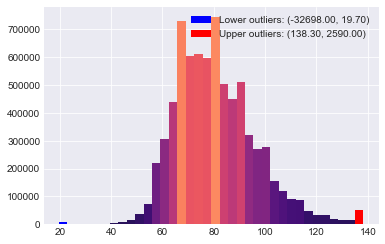

In [41]:
amsterdamumcdb.outliers_histogram(data=mean_abp['value'].dropna(), bins=36).show()

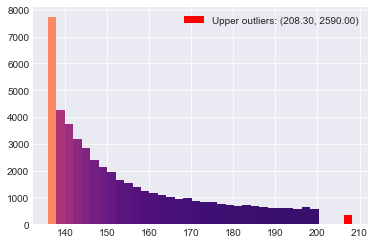

In [42]:
amsterdamumcdb.outliers_histogram(data=mean_abp.loc[mean_abp['value'] > 135, 'value'], bins=36).show()

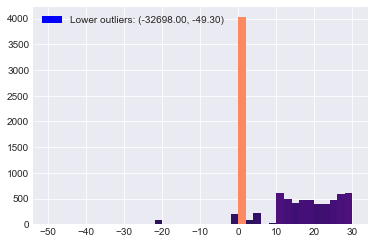

In [43]:
amsterdamumcdb.outliers_histogram(data=mean_abp.loc[mean_abp['value'] < 30, 'value']).show()

In [44]:
#remove extreme outliers, most likely data entry errors or measurement errors
mean_abp.loc[(mean_abp['value'] > 165), 'value'] = np.NaN
mean_abp.loc[(mean_abp['value'] <= 30), 'value'] = np.NaN
mean_abp = mean_abp.dropna()

In [45]:
#use mean_abp 'cleansed' dataframe
sofa_cardiovascular_map = mean_abp.groupby(['admissionid', 'itemid', 'item']).agg(
        lowest_mean_abp=pd.NamedAgg(column='value', aggfunc='min')
    ).reset_index()
sofa_cardiovascular_map.head()

,admissionid,itemid,item,lowest_mean_abp
0,0,6642,ABP gemiddeld,68.0
1,1,6642,ABP gemiddeld,59.0
2,2,6642,ABP gemiddeld,64.0
3,3,6642,ABP gemiddeld,91.0
4,4,6642,ABP gemiddeld,52.0


In [46]:
#calculate SOFA cardiovascular score:
sofa_cardiovascular_map.loc[:,'sofa_cardiovascular_score'] = 0
#MAP < 70 
sofa_cardiovascular_map.loc[(sofa_cardiovascular_map['lowest_mean_abp'] < 70), 'sofa_cardiovascular_score'] = 1

sofa_cardiovascular_map.head()

,admissionid,itemid,item,lowest_mean_abp,sofa_cardiovascular_score
0,0,6642,ABP gemiddeld,68.0,1
1,1,6642,ABP gemiddeld,59.0,1
2,2,6642,ABP gemiddeld,64.0,1
3,3,6642,ABP gemiddeld,91.0,0
4,4,6642,ABP gemiddeld,52.0,1


In [47]:
#combine the scores from MAP and cardiovascular medication
sofa_cardiovascular = pd.concat([sofa_cardiovascular_map, sofa_cardiovascular_meds], sort=False).sort_values(by='admissionid')
sofa_cardiovascular.head()

,admissionid,itemid,item,lowest_mean_abp,sofa_cardiovascular_score,total_duration,max_gamma
0,0,6642,ABP gemiddeld,68.0,1,NaN,NaN
1,1,6642,ABP gemiddeld,59.0,1,NaN,NaN
0,1,7179,Dopamine (Inotropin),NaN,2,301.0,1.666667
1,2,7229,Noradrenaline (Norepinefrine),NaN,4,89.0,0.125000
2,2,6642,ABP gemiddeld,64.0,1,NaN,NaN


#### SOFA: Central nervous system
Re-uses the data processing from the [APACHE II: GCS score](./apache_ii.ipynb#gcs).

In [48]:
# APACHE II: Glasgow Coma Score (GCS) - Score = 15 minus actual GCS - possible parameters
listitems_itemids[listitems_itemids['item'].str.contains('(?:^|\_|(?<=\W))\w*(?:Eye|ogen|Motor|Verb|GCS|EMV)\w*(?:$|\_|(?=\W))',
                                                               flags=re.IGNORECASE)]

,itemid,item,item_en,valueid,value,count,count_validated
84,6732,Actief openen van de ogen,Glasgow Coma Score eye opening subscore,1.0,Spontane reactie,103268,103268.0
85,6732,Actief openen van de ogen,Glasgow Coma Score eye opening subscore,2.0,Reactie op verbale prikkel,47877,47877.0
86,6732,Actief openen van de ogen,Glasgow Coma Score eye opening subscore,3.0,Reactie op pijnprikkel,12101,12101.0
87,6732,Actief openen van de ogen,Glasgow Coma Score eye opening subscore,4.0,Geen reactie,44421,44421.0
88,6734,Beste motore reactie van de armen,Glasgow Coma Score motor response subscore,1.0,Volgt verbale commando's op,112307,112307.0
89,6734,Beste motore reactie van de armen,Glasgow Coma Score motor response subscore,2.0,Localiseert pijn,19694,19694.0
90,6734,Beste motore reactie van de armen,Glasgow Coma Score motor response subscore,3.0,Spastische reactie (terugtrekken),23361,23361.0
91,6734,Beste motore reactie van de armen,Glasgow Coma Score motor response subscore,4.0,Decortatie reflex (abnormaal buigen),3368,3368.0
92,6734,Beste motore reactie van de armen,Glasgow Coma Score motor response subscore,5.0,Strekken,7128,7128.0
93,6734,Beste motore reactie van de armen,Glasgow Coma Score motor response subscore,6.0,Geen reactie,32463,32463.0


In [49]:
#get Glasgow Coma Scale-score
with open('../../amsterdamumcdb/sql/common/gcs.sql') as sql_file:
    sql_gcs = sql_file.read()
    display(Markdown("```sql\n" + sql_gcs + "\n```"))
gcs = pd.read_sql(sql_gcs, con)
gcs.head()

```sql
WITH gcs_components AS (
    SELECT
        eyes.admissionid,
        --eyes.itemid,
        --eyes.item,
        --eyes.value,
        --eyes.valueid,
        CASE eyes.itemid
            WHEN 6732 THEN 5 - eyes.valueid     --Actief openen van de ogen
            WHEN 13077 THEN eyes.valueid        --A_Eye
            WHEN 14470 THEN eyes.valueid - 4    --RA_Eye
            WHEN 16628 THEN eyes.valueid - 4    --MCA_Eye
            WHEN 19635 THEN eyes.valueid - 4    --E_EMV_NICE_24uur
            WHEN 19638 THEN eyes.valueid - 8    --E_EMV_NICE_Opname
        END AS eyes_score,
        --motor.value,
        --motor.valueid,
        CASE motor.itemid
            WHEN 6734 THEN 7 - motor.valueid    --Beste motore reactie van de armen
            WHEN 13072 THEN motor.valueid       --A_Motoriek
            WHEN 14476 THEN motor.valueid - 6   --RA_Motoriek
            WHEN 16634 THEN motor.valueid - 6   --MCA_Motoriek
            WHEN 19636 THEN motor.valueid - 6   --M_EMV_NICE_24uur
            WHEN 19639 THEN motor.valueid - 12  --M_EMV_NICE_Opname
        END AS motor_score,
        --verbal.value,
        --verbal.valueid,
        CASE verbal.itemid
            WHEN 6735 THEN 6 - verbal.valueid   --Beste verbale reactie
            WHEN 13066 THEN verbal.valueid      --A_Verbal
            WHEN 14482 THEN verbal.valueid - 5  --RA_Verbal
            WHEN 16640 THEN verbal.valueid - 5  --MCA_Verbal
            WHEN 19637 THEN verbal.valueid - 9 --V_EMV_NICE_24uur
            WHEN 19640 THEN verbal.valueid - 15 --V_EMV_NICE_Opname
        END AS verbal_score,
        eyes.registeredby,
        (eyes.measuredat - a.admittedat)/(1000*60) AS time
    FROM listitems eyes
    LEFT JOIN admissions a ON
        eyes.admissionid = a.admissionid
    LEFT JOIN listitems motor ON
        eyes.admissionid = motor.admissionid AND
        eyes.measuredat = motor.measuredat AND
        motor.itemid IN (
            6734, --Beste motore reactie van de armen
            13072, --A_Motoriek
            14476, --RA_Motoriek
            16634, --MCA_Motoriek
            19636, --M_EMV_NICE_24uur
            19639 --M_EMV_NICE_Opname
        )
    LEFT JOIN listitems verbal ON
        eyes.admissionid = verbal.admissionid AND
        eyes.measuredat = verbal.measuredat AND
        verbal.itemid IN (
            6735, --Beste verbale reactie
            13066, --A_Verbal
            14482, --RA_Verbal
            16640, --MCA_Verbal
            19637, --V_EMV_NICE_24uur
            19640 --V_EMV_NICE_Opname
        )
    WHERE eyes.itemid IN (
        6732, --Actief openen van de ogen
        13077, --A_Eye
        14470, --RA_Eye
        16628, --MCA_Eye
        19635, --E_EMV_NICE_24uur
        19638 --E_EMV_NICE_Opname
        )
    -- measurements within 24 hours of ICU stay:
    AND (eyes.measuredat - a.admittedat) <= 1000*60*60*24 AND (eyes.measuredat - a.admittedat) >= 0
), gcs AS (
    SELECT *,
        eyes_score + motor_score + (
            CASE
                WHEN verbal_score < 1 THEN 1
                ELSE verbal_score
            END
        ) AS gcs_score
    FROM gcs_components
), gcs_prioritized AS (
    SELECT *,
        ROW_NUMBER() OVER(
            PARTITION BY admissionid
            ORDER BY --orders by discipline
                CASE registeredby
                    WHEN 'ICV_Medisch Staflid' THEN 1
                    WHEN 'ICV_Medisch' THEN 2
                    WHEN 'ANES_Anesthesiologie'THEN 3
                    WHEN 'ICV_Physician assistant' THEN 4
                    WHEN 'ICH_Neurochirurgie'THEN 5
                    WHEN 'ICV_IC-Verpleegkundig' THEN 6
                    WHEN 'ICV_MC-Verpleegkundig' THEN 7
                    ELSE 8
                END, gcs_score
        ) AS priority
    FROM gcs
    ORDER BY admissionid, gcs_score ASC
)
SELECT *
FROM gcs_prioritized
WHERE priority = 1
```

,admissionid,eyes_score,motor_score,verbal_score,registeredby,time,gcs_score,priority
0,0,4,6.0,5.0,ICV_Medisch,733,15.0,1
1,1,4,6.0,5.0,ICV_Medisch,1372,15.0,1
2,2,4,6.0,5.0,ICV_Medisch,1256,15.0,1
3,4,1,1.0,1.0,ICV_Medisch,103,3.0,1
4,5,4,6.0,5.0,ICV_Medisch Staflid,22,15.0,1


In [50]:
sofa_cns = gcs.groupby(['admissionid']).agg(
        min_gcs=pd.NamedAgg(column='gcs_score', aggfunc='min')
    ).reset_index()
sofa_cns.head()

,admissionid,min_gcs
0,0,15.0
1,1,15.0
2,2,15.0
3,4,3.0
4,5,15.0


In [51]:
#calculate SOFA Central nervous system score:
sofa_cns.loc[:,'sofa_cns_score'] = 0
sofa_cns.loc[(sofa_cns['min_gcs'] >= 13) & (sofa_cns['min_gcs'] < 15), 'sofa_cns_score'] = 1
sofa_cns.loc[(sofa_cns['min_gcs'] >= 10) & (sofa_cns['min_gcs'] < 13), 'sofa_cns_score'] = 2
sofa_cns.loc[(sofa_cns['min_gcs'] >= 6) & (sofa_cns['min_gcs'] < 10), 'sofa_cns_score'] = 3
sofa_cns.loc[(sofa_cns['min_gcs'] < 6), 'sofa_cns_score'] = 4
sofa_cns.head()

,admissionid,min_gcs,sofa_cns_score
0,0,15.0,0
1,1,15.0,0
2,2,15.0,0
3,4,3.0,4
4,5,15.0,0


#### SOFA: Renal - Creatinine or urine output

In [52]:
# SOFA urine output - possible parameters
#get urineoutput
sql_renal_params = """
SELECT DISTINCT itemid, item FROM numericitems
WHERE fluidout > 0
"""
renal_params = pd.read_sql(sql_renal_params, con)
renal_params.head()

,itemid,item
0,8925,Maagzuig
1,8798,UrineSpontaan
2,12503,Thoraxdrain4 Productie
3,8780,Braken
4,8789,Ontlasting


In [53]:
renal_params

,itemid,item
0,8925,Maagzuig
1,8798,UrineSpontaan
2,12503,Thoraxdrain4 Productie
3,8780,Braken
4,8789,Ontlasting
5,19921,UrineSplint Li
6,8806,Hemodialyse onttrekken
7,8794,UrineCAD
8,10743,Nefrodrain li Uit
9,9564,NDT-syst.


In [54]:
#get urineoutput
with open('../../amsterdamumcdb/sql/common/urine_output.sql') as sql_file:
    sql_sofa_renal_urine_output = sql_file.read()
    display(Markdown("```sql\n" + sql_sofa_renal_urine_output + "\n```"))
sofa_renal_urine_output = pd.read_sql(sql_sofa_renal_urine_output, con)
sofa_renal_urine_output.head()

```sql
SELECT
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    8794, --UrineCAD
    8796, --UrineSupraPubis
    8798, --UrineSpontaan
    8800, --UrineIncontinentie
    8803, --UrineUP
    10743, --Nefrodrain li Uit
    10745, --Nefrodrain re Uit
    19921, --UrineSplint Li
    19922 --UrineSplint Re
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= 0
```

,admissionid,itemid,item,value,registeredby,time
0,0,8794,UrineCAD,90.0,ICV_IC-Verpleegkundig,342
1,0,8794,UrineCAD,310.0,ICV_IC-Verpleegkundig,372
2,0,8794,UrineCAD,360.0,ICV_IC-Verpleegkundig,432
3,0,8794,UrineCAD,180.0,ICV_IC-Verpleegkundig,492
4,0,8794,UrineCAD,120.0,ICV_IC-Verpleegkundig,552


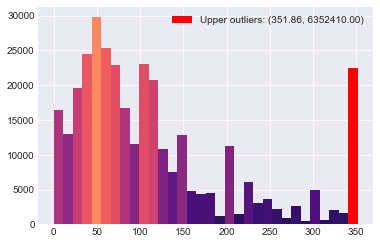

In [55]:
amsterdamumcdb.outliers_histogram(data=sofa_renal_urine_output['value'], bins=32).show()

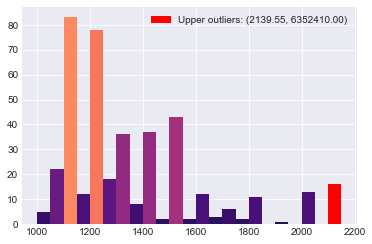

In [56]:
amsterdamumcdb.outliers_histogram(data=sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 1000), 'value']).show()

In [57]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
sofa_renal_urine_output.loc[sofa_renal_urine_output['admissionid'].isin(
    sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 2500), 'admissionid'])
             ].sort_values(by='admissionid').head(5)

,admissionid,itemid,item,value,registeredby,time
57618,4170,8794,UrineCAD,2550.0,ICV_IC-Verpleegkundig,23
57633,4170,8794,UrineCAD,150.0,ICV_MC-Verpleegkundig,923
57632,4170,8794,UrineCAD,115.0,ICV_MC-Verpleegkundig,863
57631,4170,8794,UrineCAD,100.0,ICV_MC-Verpleegkundig,803
57630,4170,8794,UrineCAD,85.0,ICV_MC-Verpleegkundig,743


In [58]:
#probably decimal error when entering volumes > 2500
sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 2500), 'value'] = sofa_renal_urine_output['value']/10

In [59]:
#remove extreme outliers, most likely data entry error)
sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 4500), 'value'] = np.NaN
sofa_renal_urine_output = sofa_renal_urine_output.dropna()

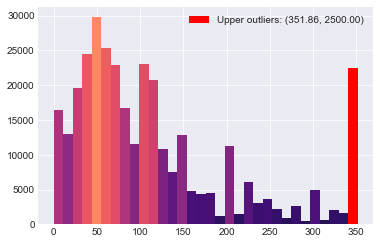

In [60]:
amsterdamumcdb.outliers_histogram(data=sofa_renal_urine_output['value'], bins=32).show()

In [61]:
#get urine output per 24 hours
sofa_renal_daily_urine_output = sofa_renal_urine_output.groupby(['admissionid']).agg(
        daily_urine_output=pd.NamedAgg(column='value', aggfunc='sum')
    ).reset_index()
sofa_renal_daily_urine_output.head()

,admissionid,daily_urine_output
0,0,2005.0
1,1,2540.0
2,2,1785.0
3,3,2301.0
4,4,1155.0


In [62]:
#calculate SOFA renal score for urine output:
sofa_renal_daily_urine_output.loc[:,'sofa_renal_score'] = 0

#urine output < 500 ml/day
sofa_renal_daily_urine_output.loc[( 
    ((sofa_renal_daily_urine_output['daily_urine_output'] < 500) & 
     (sofa_renal_daily_urine_output['daily_urine_output'] > 200))
), 'sofa_renal_score'] = 3

#urine output < 200 ml/day
sofa_renal_daily_urine_output.loc[( 
    ((sofa_renal_daily_urine_output['daily_urine_output'] < 200))
), 'sofa_renal_score'] = 4
             
sofa_renal_daily_urine_output.head()

,admissionid,daily_urine_output,sofa_renal_score
0,0,2005.0,0
1,1,2540.0,0
2,2,1785.0,0
3,3,2301.0,0
4,4,1155.0,0


##### serum creatinine
Re-uses the data processing from the [APACHE II: Serum creatinine score](./apache_ii.ipynb#creatinine).

In [63]:
# APACHE II: Serum creatinine (mg/100 ml) - possible parameters
numericitems_itemids[numericitems_itemids['item'].str.contains('(?:^|(?<=\W))(?:k|c)?reat(?:inin)?(?:e)?(?:$|(?=\W))', flags=re.IGNORECASE)]

,itemid,item,item_en,unitid,unit,count,count,count_validated
160,6836,Kreatinine,serum creatinine,56.0,µmol,6481,6481,6481.0
301,7108,Kreatinine klaring,NaN,24.0,ml/min,2,2,2.0
302,7109,Kreatinine in urine,NaN,97.0,mmol/l,47,47,47.0
1689,9941,Kreatinine (bloed),serum creatinine,99.0,µmol/l,196186,196186,196186.0
1690,9942,Kreatinine (Jaffé) (overig),NaN,99.0,µmol/l,43,43,43.0
1841,10279,Kreatinine (urine),NaN,97.0,mmol/l,3340,3340,3340.0
2575,11900,Kreat.klaring (urine),NaN,24.0,ml/min,91,91,91.0
2576,11901,KREAT.KLAR (verz. urine),NaN,24.0,ml/min,167,167,167.0
2845,12191,Kreatinine (Jaffé) (overig),NaN,97.0,mmol/l,16,16,16.0
2846,12192,Kreatinine (verz. urine),NaN,97.0,mmol/l,506,506,506.0


In [64]:
#get serum creatinine
with open('../../amsterdamumcdb/sql/common/creatinine_acute_kidney_injury_failure.sql') as sql_file:
    sql_creatinine = sql_file.read()
    display(Markdown("```sql\n" + sql_creatinine + "\n```"))
creatinine = pd.read_sql(sql_creatinine, con)
creatinine.head()

```sql
WITH baseline AS (
    SELECT n.admissionid,
    MIN(n.value) AS baseline_creatinine
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        6836, --Kreatinine Âµmol/l (erroneously documented as Âµmol)
        9941, --Kreatinine (bloed) Âµmol/l
        14216 --KREAT enzym. (bloed) Âµmol/l
    ) AND
    --search upto 1 year before admission
    (n.measuredat - a.admittedat)/(60*60*1000) > -(365*24) AND (n.measuredat - a.admittedat) < (24*60*60*1000)
    GROUP BY n.admissionid
),
max_creat AS (
    SELECT n.admissionid,
    MAX(n.value) AS max_creatinine_7days
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        6836, --Kreatinine Âµmol/l (erroneously documented as Âµmol)
        9941, --Kreatinine (bloed) Âµmol/l
        14216 --KREAT enzym. (bloed) Âµmol/l
    ) AND
    --within 7 days of admission
    (n.measuredat - a.admittedat) > 0 AND (n.measuredat - a.admittedat) < (7*24*60*60*1000)
    GROUP BY n.admissionid
)
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN n.registeredby NOT ILIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time,
    b.baseline_creatinine,
    m.max_creatinine_7days,
    CASE
        -- AKI definition: 3 fold increase:
        WHEN baseline_creatinine > 0 AND m.max_creatinine_7days/baseline_creatinine > 3 THEN TRUE
        -- AKI definition: increase to >= 354 umol/l AND at least 44 umol/l increase:
        WHEN max_creatinine_7days >= 354 AND max_creatinine_7days - baseline_creatinine >= 44 THEN TRUE 
        ELSE FALSE
    END AS acute_renal_failure
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
LEFT JOIN baseline b ON -- get the baseline kreat (before admission)
    n.admissionid = b.admissionid
LEFT JOIN max_creat m ON --get the highest within a week of admission
    n.admissionid = m.admissionid
WHERE n.itemid IN (
    6836, --Kreatinine Âµmol/l (erroneously documented as Âµmol)
    9941, --Kreatinine (bloed) Âµmol/l
    14216 --KREAT enzym. (bloed) Âµmol/l
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)
```

,admissionid,itemid,item,value,registeredby,manual_entry,time,baseline_creatinine,max_creatinine_7days,acute_renal_failure
0,12,6836,Kreatinine,77.0,ICV_Medisch,True,15,77.0,77.0,False
1,43,6836,Kreatinine,70.0,ICV_Medisch,True,50,66.0,70.0,False
2,43,6836,Kreatinine,66.0,ICV_IC-Verpleegkundig,True,830,66.0,70.0,False
3,102,6836,Kreatinine,84.0,ICV_Medisch,True,60,84.0,84.0,False
4,130,6836,Kreatinine,106.0,ICV_Medisch,True,121,106.0,106.0,False


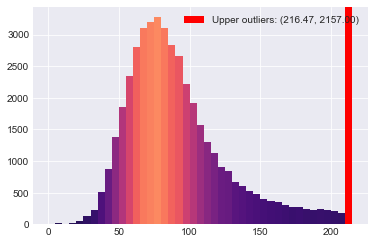

In [65]:
amsterdamumcdb.outliers_histogram(data=creatinine['value']).show()

In [66]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
creatinine.loc[creatinine['admissionid'].isin(
    creatinine.loc[(creatinine['value']> 1000) & (creatinine['manual_entry'] == True), 'admissionid'])
             ].sort_values(by='admissionid')

,admissionid,itemid,item,value,registeredby,manual_entry,time,baseline_creatinine,max_creatinine_7days,acute_renal_failure
421,5819,6836,Kreatinine,1013.0,ICV_IC-Verpleegkundig,True,12,385.0,1013.0,True
422,5819,6836,Kreatinine,680.0,ICV_IC-Verpleegkundig,True,672,385.0,1013.0,True
423,5819,6836,Kreatinine,385.0,ICV_Medisch Staflid,True,1392,385.0,1013.0,True
16717,7637,9941,Kreatinine (bloed),2157.0,ICV_Medisch Staflid,True,1,1078.0,2157.0,True
16718,7637,9941,Kreatinine (bloed),1720.0,Systeem,False,156,1078.0,2157.0,True
16719,7637,9941,Kreatinine (bloed),1144.0,Systeem,False,718,1078.0,2157.0,True
16720,7637,9941,Kreatinine (bloed),1078.0,Systeem,False,1111,1078.0,2157.0,True
27746,13151,9941,Kreatinine (bloed),1291.0,Systeem,False,70,1291.0,1355.0,True
27747,13151,9941,Kreatinine (bloed),1355.0,ICV_IC-Verpleegkundig,True,409,1291.0,1355.0,True


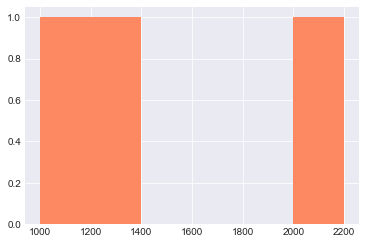

In [67]:
amsterdamumcdb.outliers_histogram(data=creatinine.loc[(creatinine['value'] > 1000) & (creatinine['manual_entry'] == True), 'value']).show()

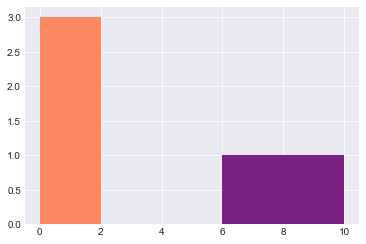

In [68]:
amsterdamumcdb.outliers_histogram(data=creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'value']).show()

In [69]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
creatinine.loc[creatinine['admissionid'].isin(
    creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'admissionid'])
             ].sort_values(by='admissionid')

,admissionid,itemid,item,value,registeredby,manual_entry,time,baseline_creatinine,max_creatinine_7days,acute_renal_failure
523,7132,6836,Kreatinine,113.0,ICV_IC-Verpleegkundig,True,275,0.0,113.0,False
524,7132,6836,Kreatinine,0.0,ICV_IC-Verpleegkundig,True,514,0.0,113.0,False
525,7132,6836,Kreatinine,107.0,ICV_Medisch,True,875,0.0,113.0,False
1008,13794,6836,Kreatinine,113.0,ICV_IC-Verpleegkundig,True,109,11.0,118.0,True
1009,13794,6836,Kreatinine,112.0,ICV_IC-Verpleegkundig,True,649,11.0,118.0,True
1010,13794,6836,Kreatinine,11.0,ICV_IC-Verpleegkundig,True,949,11.0,118.0,True
32604,15626,9941,Kreatinine (bloed),219.0,Systeem,False,144,0.0,330.0,False
32605,15626,9941,Kreatinine (bloed),330.0,Systeem,False,1091,0.0,330.0,False
1156,15626,6836,Kreatinine,219.0,ICV_IC-Verpleegkundig,True,131,0.0,330.0,False
1157,15626,6836,Kreatinine,0.0,ICV_IC-Verpleegkundig,True,191,0.0,330.0,False


In [70]:
#remove extreme outliers, most likely data entry errors (manual_entry = True)
creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'value'] = np.NaN
creatinine = creatinine.dropna(subset=['value'])

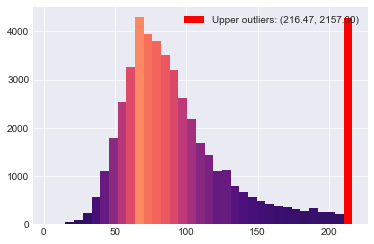

In [71]:
#amsterdamumcdb.outliers_histogram(data=creatinine.loc[creatinine['manual_entry'] == False, 'value']).show()
amsterdamumcdb.outliers_histogram(data=creatinine['value'], bins=35).show()

In [72]:
#get highest creatinine per 24 hours 
#use creatinine 'cleansed' dataframe from APACHE score
sofa_renal_creatinine = creatinine.groupby(['admissionid']).agg(
        max_creatinine=pd.NamedAgg(column='value', aggfunc='max')
    ).reset_index()
sofa_renal_creatinine.head()

,admissionid,max_creatinine
0,0,86.0
1,1,91.0
2,2,81.0
3,3,113.0
4,4,98.0


In [73]:
#calculate SOFA renal score for creatinine:
sofa_renal_creatinine.loc[:,'sofa_renal_score'] = 0

#creatinine 110-170 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] >= 110) & 
     (sofa_renal_creatinine['max_creatinine'] < 171))
), 'sofa_renal_score'] = 1

#creatinine 171-299 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] >= 171) & 
     (sofa_renal_creatinine['max_creatinine'] < 300))
), 'sofa_renal_score'] = 2

#creatinine 300-440 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] >= 300) & 
     (sofa_renal_creatinine['max_creatinine'] <= 440))
), 'sofa_renal_score'] = 3

#creatinine >440 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] > 440))
), 'sofa_renal_score'] = 4

sofa_renal_creatinine.head()

,admissionid,max_creatinine,sofa_renal_score
0,0,86.0,0
1,1,91.0,0
2,2,81.0,0
3,3,113.0,1
4,4,98.0,0


In [74]:
#combine the scores from creatinine and urine output
sofa_renal = pd.concat([sofa_renal_creatinine, sofa_renal_daily_urine_output], sort=False).sort_values(by='admissionid')
sofa_renal.head()

,admissionid,max_creatinine,sofa_renal_score,daily_urine_output
0,0,86.0,0,NaN
0,0,NaN,0,2005.0
1,1,91.0,0,NaN
1,1,NaN,0,2540.0
2,2,81.0,0,NaN


In [75]:
sofa_renal.head()

,admissionid,max_creatinine,sofa_renal_score,daily_urine_output
0,0,86.0,0,NaN
0,0,NaN,0,2005.0
1,1,91.0,0,NaN
1,1,NaN,0,2540.0
2,2,81.0,0,NaN


In [76]:
#merge the scores
sofa = admissions['admissionid']

#max respiration score 
scores = sofa_respiration.groupby('admissionid')['sofa_respiration_score'].max().to_frame(
    'sofa_respiration_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max coagulation score 
scores = sofa_platelets.groupby('admissionid')['sofa_coagulation_score'].max().to_frame(
    'sofa_coagulation_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max liver score 
scores = sofa_bilirubin.groupby('admissionid')['sofa_liver_score'].max().to_frame(
    'sofa_liver_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max cardiovascular score 
scores = sofa_cardiovascular.groupby('admissionid')['sofa_cardiovascular_score'].max().to_frame(
    'sofa_cardiovascular_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max central nervous system score 
scores = sofa_cns.groupby('admissionid')['sofa_cns_score'].max().to_frame(
    'sofa_cns_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max renal score 
scores = sofa_renal.groupby('admissionid')['sofa_renal_score'].max().to_frame(
    'sofa_renal_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#calculate total score (add al values in columns)
total_scores = sofa.set_index('admissionid').sum(axis=1, skipna=True).to_frame('sofa_total_score')
sofa = pd.merge(sofa, total_scores, on='admissionid', how='left')
sofa.head()

,admissionid,sofa_respiration_score,sofa_coagulation_score,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total_score
0,0,3.0,0.0,NaN,1.0,0.0,0.0,4.0
1,1,2.0,1.0,NaN,2.0,0.0,0.0,5.0
2,2,2.0,0.0,NaN,4.0,0.0,0.0,6.0
3,3,2.0,0.0,NaN,0.0,NaN,1.0,3.0
4,4,3.0,0.0,0.0,2.0,4.0,0.0,9.0


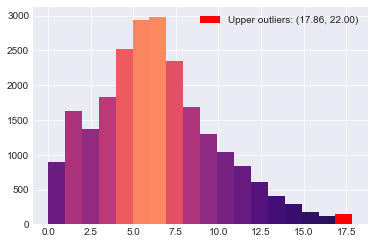

In [77]:
amsterdamumcdb.outliers_histogram(data=sofa['sofa_total_score'],bins=18).show()

Add location for easier selection:

In [78]:
sofa = pd.merge(sofa, admissions[['admissionid','location','urgency']], on='admissionid', how='left')
sofa.loc[:,'urgency'] = pd.to_numeric(sofa.loc[:,'urgency'])

In [79]:
sofa_total = sofa.sofa_total_score.median()
sofa_iqr1_total = sofa.sofa_total_score.quantile(0.25)
sofa_iqr2_total = sofa.sofa_total_score.quantile(0.75)

sofa_ICU = sofa.loc[sofa['location'].str.contains('IC'), 'sofa_total_score'].median()
sofa_iqr1_ICU = sofa.loc[sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_ICU = sofa.loc[sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.75)

sofa_MCU = sofa.loc[sofa['location'].str.contains('^MC$'), 'sofa_total_score'].median()
sofa_iqr1_MCU = sofa.loc[sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_MCU = sofa.loc[sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.75)

In [80]:
sofa_total_urgent = sofa.loc[sofa['urgency'] == 1].sofa_total_score.median()
sofa_iqr1_total_urgent = sofa.loc[sofa['urgency'] == 1].sofa_total_score.quantile(0.25)
sofa_iqr2_total_urgent = sofa.loc[sofa['urgency'] == 1].sofa_total_score.quantile(0.75)

sofa_ICU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('IC'), 'sofa_total_score'].median()
sofa_iqr1_ICU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_ICU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.75)

sofa_MCU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].median()
sofa_iqr1_MCU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_MCU_urgent = sofa.loc[(sofa['urgency'] == 1) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.75)

In [81]:
sofa_total_nonurgent = sofa.loc[sofa['urgency'] == 0].sofa_total_score.median()
sofa_iqr1_total_nonurgent = sofa.loc[sofa['urgency'] == 0].sofa_total_score.quantile(0.25)
sofa_iqr2_total_nonurgent = sofa.loc[sofa['urgency'] == 0].sofa_total_score.quantile(0.75)

sofa_ICU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('IC'), 'sofa_total_score'].median()
sofa_iqr1_ICU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_ICU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('IC'), 'sofa_total_score'].quantile(0.75)

sofa_MCU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].median()
sofa_iqr1_MCU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.25)
sofa_iqr2_MCU_nonurgent = sofa.loc[(sofa['urgency'] == 0) & sofa['location'].str.contains('^MC$'), 'sofa_total_score'].quantile(0.75)

## Create the actual table in html

In [82]:
display(Markdown("""
<table>
    <thead>
        <tr>
            <th style="text-align:left;">Patient Characteristics</th>
            <th style="text-align:right;">Total</th>
            <th style="text-align:right;">ICU</th>
            <th style="text-align:right;">MCU</th>
        </tr>
        <tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align:left">Distinct patients, no.</td>
            <td>{no_patients_total}</td>
            <td>{no_patients_ICU}</td>
            <td>{no_patients_MCU}</td>
        </tr>    
        <tr>
            <td style="text-align:left">ICU admissions, no.</td>
            <td>{no_admissions_total}</td>
            <td>{no_admissions_ICU}</td>
            <td>{no_admissions_MCU}</td>
        </tr>    
        <tr>
            <th style="text-align:left" colspan=4>Severity Scores</th>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Urgent patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">SOFA score (day 1) (median [IQR])</td>
            <td>{sofa_total_urgent:.0f} [{sofa_iqr1_total_urgent:.0f}, {sofa_iqr2_total_urgent:.0f}]</td>
            <td>{sofa_ICU_urgent:.0f} [{sofa_iqr1_ICU_urgent:.0f}, {sofa_iqr2_ICU_urgent:.0f}]</td>
            <td>{sofa_MCU_urgent:.0f} [{sofa_iqr1_MCU_urgent:.0f}, {sofa_iqr2_MCU_urgent:.0f}]</td>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Elective patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">SOFA score (day 1) (median [IQR])</td>
            <td>{sofa_total_nonurgent:.0f} [{sofa_iqr1_total_nonurgent:.0f}, {sofa_iqr2_total_nonurgent:.0f}]</td>
            <td>{sofa_ICU_nonurgent:.0f} [{sofa_iqr1_ICU_nonurgent:.0f}, {sofa_iqr2_ICU_nonurgent:.0f}]</td>
            <td>{sofa_MCU_nonurgent:.0f} [{sofa_iqr1_MCU_nonurgent:.0f}, {sofa_iqr2_MCU_nonurgent:.0f}]</td>
        </tr>
    </tbody>
</table>
""".format(
            #No. patients
            no_patients_total = no_patients_total,
            no_patients_ICU = no_patients_ICU,
            no_patients_MCU = no_patients_MCU,

            #No. admissions
            no_admissions_total = no_admissions_total,
            no_admissions_ICU = no_admissions_ICU,
            no_admissions_MCU = no_admissions_MCU,

            #Severity scores
            #Urgent   
            #SOFA (Vincent, ICM, 1996)
            sofa_total_urgent = sofa_total_urgent,
            sofa_iqr1_total_urgent = sofa_iqr1_total_urgent,
            sofa_iqr2_total_urgent = sofa_iqr2_total_urgent,

            sofa_ICU_urgent = sofa_ICU_urgent,
            sofa_iqr1_ICU_urgent = sofa_iqr1_ICU_urgent,
            sofa_iqr2_ICU_urgent = sofa_iqr2_ICU_urgent,

            sofa_MCU_urgent = sofa_MCU_urgent,
            sofa_iqr1_MCU_urgent = sofa_iqr1_MCU_urgent,
            sofa_iqr2_MCU_urgent = sofa_iqr2_MCU_urgent,
    
            ## Non-urgent   
            #SOFA (Vincent, ICM, 1996)
            sofa_total_nonurgent = sofa_total_nonurgent,
            sofa_iqr1_total_nonurgent = sofa_iqr1_total_nonurgent,
            sofa_iqr2_total_nonurgent = sofa_iqr2_total_nonurgent,

            sofa_ICU_nonurgent = sofa_ICU_nonurgent,
            sofa_iqr1_ICU_nonurgent = sofa_iqr1_ICU_nonurgent,
            sofa_iqr2_ICU_nonurgent = sofa_iqr2_ICU_nonurgent,

            sofa_MCU_nonurgent = sofa_MCU_nonurgent,
            sofa_iqr1_MCU_nonurgent = sofa_iqr1_MCU_nonurgent,
            sofa_iqr2_MCU_nonurgent = sofa_iqr2_MCU_nonurgent
        )
    )
)


<table>
    <thead>
        <tr>
            <th style="text-align:left;">Patient Characteristics</th>
            <th style="text-align:right;">Total</th>
            <th style="text-align:right;">ICU</th>
            <th style="text-align:right;">MCU</th>
        </tr>
        <tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align:left">Distinct patients, no.</td>
            <td>20109</td>
            <td>16518</td>
            <td>4295</td>
        </tr>    
        <tr>
            <td style="text-align:left">ICU admissions, no.</td>
            <td>23106</td>
            <td>18386</td>
            <td>4720</td>
        </tr>    
        <tr>
            <th style="text-align:left" colspan=4>Severity Scores</th>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Urgent patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">SOFA score (day 1) (median [IQR])</td>
            <td>7 [4, 10]</td>
            <td>8 [5, 10]</td>
            <td>2 [1, 4]</td>
        </tr>
        <tr>
            <td style="text-align:left" colspan=4><i>Elective patients</i></td>
        </tr>
        <tr>
            <td style="text-align:left">SOFA score (day 1) (median [IQR])</td>
            <td>5 [4, 7]</td>
            <td>6 [4, 8]</td>
            <td>2 [1, 4]</td>
        </tr>
    </tbody>
</table>


In [83]:
#write to csv for re-use
sofa.to_csv('sofa.csv', index=False)